# Find a vacation destination with Agents - Single Agent

## Scenario

In this example we are going to create an Agent that will have access to tools to find a vacation destination. You will be able to ask this agent questions, watch it call the required tools, and have conversations with it.

1. Create an agent to find vacation destination based on user's profile and travel history of similar users. This agent will have access to tool that can search based on available travel history data.


<img src="scenario.png" alt="Scenario" style="width:800px;height:auto;"/>

## Setup

Let's start with installing required packages. 

In [6]:
%pip install -U langchain-community langgraph langchain-chroma langchain_aws pandas

  Using cached langchain_community-0.3.1-py3-none-any.whl.metadata (2.8 kB)
  Using cached langchain_chroma-0.1.4-py3-none-any.whl.metadata (1.6 kB)
  Using cached pandas-2.2.3-cp311-cp311-macosx_11_0_arm64.whl.metadata (89 kB)
  Using cached pydantic_settings-2.5.2-py3-none-any.whl.metadata (3.5 kB)
  Using cached langchain_text_splitters-0.3.0-py3-none-any.whl.metadata (2.3 kB)
  Using cached msgpack-1.1.0-cp311-cp311-macosx_11_0_arm64.whl.metadata (8.4 kB)
  Using cached requests_toolbelt-1.0.0-py2.py3-none-any.whl.metadata (14 kB)
Using cached langchain_community-0.3.1-py3-none-any.whl (2.4 MB)
Using cached langchain_chroma-0.1.4-py3-none-any.whl (10 kB)
Using cached pandas-2.2.3-cp311-cp311-macosx_11_0_arm64.whl (11.3 MB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 16.8 MB/s eta 0:00:00
Using cached pydantic_settings-2.5.2-py3-none-any.whl (26 kB)
Using cached langchain_text_splitters-0.3.0-py3-none-any.whl (25 kB)
Using cached msgpack-1.1.0-cp311-cp311-macosx_11_0_arm6

!!! warning
    Execute 00_data_prep.ipynb in this folder to create data for the example.

:::warning

Execute 00_data_prep.ipynb in this folder to create data for the example.

:::

For observability you can use LangSmith. You need to sign up and use the API Key.  

:::info

This is an optional step that will help you understand how your agents are working.

:::

In [1]:
import getpass
import os

os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_API_KEY"] = getpass.getpass()
os.environ["LANGCHAIN_PROJECT"] = "lc-agent-sample"

Now create Bedrock client that is used to configure LLM in LangChain to use Bedrock.

In [1]:
from langchain_aws import ChatBedrock
import boto3

# ---- ⚠️ Update region for your AWS setup ⚠️ ----
bedrock_client = boto3.client("bedrock-runtime", region_name="us-east-1")

## Tools

Let's create tools that will be used by our agents to find a vacation destination based on user' profile and travel history of similar users.

Tools are external resources, services, or APIs that an LLM agent can access and utilize to expand its capabilities and perform specific tasks. These supplementary components allow the agent to go beyond its core language processing abilities, enabling it to interact with external systems, retrieve information, or execute actions that would otherwise be outside its scope. By integrating tools, LLM agents can provide more comprehensive and practical solutions to user queries and commands.

We will create a tool that uses historic travel information of different users to find a vacation destination based on user' profile and travel history of similar users. The tool will use the local csv file to retrieve historical data about travel destinations. It will then analyze the data and return the most popular destination for the user.



We will use LangChain Tools to create tools that are used by our agents. These are utilities designed to be called by a model: their inputs are designed to be generated by models, and their outputs are designed to be passed back to models. Tools are needed whenever you want a model to control parts of your code or call out to external APIs.

A tool consists of:

- The name of the tool.
- A description of what the tool does.
- A JSON schema defining the inputs to the tool.
- A function (and, optionally, an async variant of the function)

When a tool is bound to a model, the name, description and JSON schema are provided as context to the model. Given a list of tools and a set of instructions, a model can request to call one or more tools with specific inputs. 

In [2]:
import pandas as pd
from collections import Counter
from langchain_core.tools import tool


def read_travel_data(file_path: str = "data/synthetic_travel_data.csv") -> pd.DataFrame:
    """Read travel data from CSV file"""
    try:
        df = pd.read_csv(file_path)
        return df
    except FileNotFoundError:
        return pd.DataFrame(
            columns=[
                "Name",
                "Current_Location",
                "Age",
                "Past_Travel_Destinations",
                "Number_of_Trips",
                "Flight_Number",
                "Departure_City",
                "Arrival_City",
                "Flight_Date",
            ]
        )


@tool
def compare_and_recommend_destination(name: str) -> str:
    """This tool is used to check which destinations user has already traveled. 
    Use name of the user to fetch the information about that user.
    If user has already been to a city then do not recommend that city. 
    
    Args:
        name (str): Name of the user.
    Returns:
        str: Destination to be recommended.
    
    """

    df = read_travel_data()

    if name not in df["Name"].values:
        return "User not found in the travel database."

    user_data = df[df["Name"] == name].iloc[0]
    current_location = user_data["Current_Location"]
    age = user_data["Age"]
    past_destinations = user_data["Past_Travel_Destinations"].split(", ")

    # Get all past destinations of users with similar age (±5 years) and same current location
    similar_users = df[
        (df["Current_Location"] == current_location)
        & (df["Age"].between(age - 5, age + 5))
    ]
    all_destinations = [
        dest
        for user_dests in similar_users["Past_Travel_Destinations"].str.split(", ")
        for dest in user_dests
    ]

    # Count occurrences of each destination
    destination_counts = Counter(all_destinations)

    # Remove user's current location and past destinations from recommendations
    for dest in [current_location] + past_destinations:
        if dest in destination_counts:
            del destination_counts[dest]

    if not destination_counts:
        return f"No new recommendations found for users in {current_location} with similar age."

    # Get the most common destination
    recommended_destination = destination_counts.most_common(1)[0][0]

    return f"Based on your current location ({current_location}), age ({age}), and past travel data, we recommend visiting {recommended_destination}."

In [3]:
tools = [compare_and_recommend_destination]

## Language Model

Let's learn how to use a LLM with tools. 

To integrate LLM from Amazon Bedrock, we are going to use `ChatBedrockConverse` class of LangChain. We also need to use `bedrock_client` to connect to Bedrock.

In [4]:
from langchain_aws import ChatBedrockConverse

llm = ChatBedrockConverse(
    model="anthropic.claude-3-sonnet-20240229-v1:0",
    # model="anthropic.claude-3-5-sonnet-20240620-v1:0",
    temperature=0,
    max_tokens=None,
    client=bedrock_client,
    # other params...
)

## Create Agent

Now that we have defined the tools and the LLM, we can create the agent. We will be using LangGraph to construct the agent. Currently we are using a high level interface to construct the agent, but the nice thing about LangGraph is that this high-level interface is backed by a low-level, highly controllable API in case you want to modify the agent logic.

Now, we can initialize the agent with the LLM and the tools.

In [5]:
from langgraph.prebuilt import create_react_agent

agent_executor = create_react_agent(llm, tools)

We are ready to test our agent with a sample input!

In [9]:
from langchain_core.messages import HumanMessage

response = agent_executor.invoke(
    {
        "messages": [
            HumanMessage(
                content="My name is Walter Martinez, suggest me a good vacation destination."
            )
        ]
    }
)

response["messages"]

[HumanMessage(content='My name is Walter Martinez, suggest me a good vacation destination.', additional_kwargs={}, response_metadata={}, id='cf77321a-1e5d-483d-8398-2ee6ea022406'),
 AIMessage(content=[{'type': 'text', 'text': 'Okay, let me invoke the tool to check which destinations you have already visited and recommend a new one.'}, {'type': 'tool_use', 'name': 'compare_and_recommend_destination', 'input': {'name': 'Walter Martinez'}, 'id': 'tooluse_v3epZ1CQRQ6sbx2c8YFeUQ'}], additional_kwargs={}, response_metadata={'ResponseMetadata': {'RequestId': 'f3684518-ba6f-43cb-aa90-fe884c862663', 'HTTPStatusCode': 200, 'HTTPHeaders': {'date': 'Fri, 04 Oct 2024 19:33:48 GMT', 'content-type': 'application/json', 'content-length': '427', 'connection': 'keep-alive', 'x-amzn-requestid': 'f3684518-ba6f-43cb-aa90-fe884c862663'}, 'RetryAttempts': 0}, 'stopReason': 'tool_use', 'metrics': {'latencyMs': 2486}}, id='run-28d8e833-0967-4735-bc67-c5b441da3911-0', tool_calls=[{'name': 'compare_and_recommend

The basic version is running. In order to see exactly what is happening under the hood we can take a look at the LangSmith trace

Trace in LangSmith clearly shows that model is able to use `recommend_destination` tool and generating the final output based on the tool output.

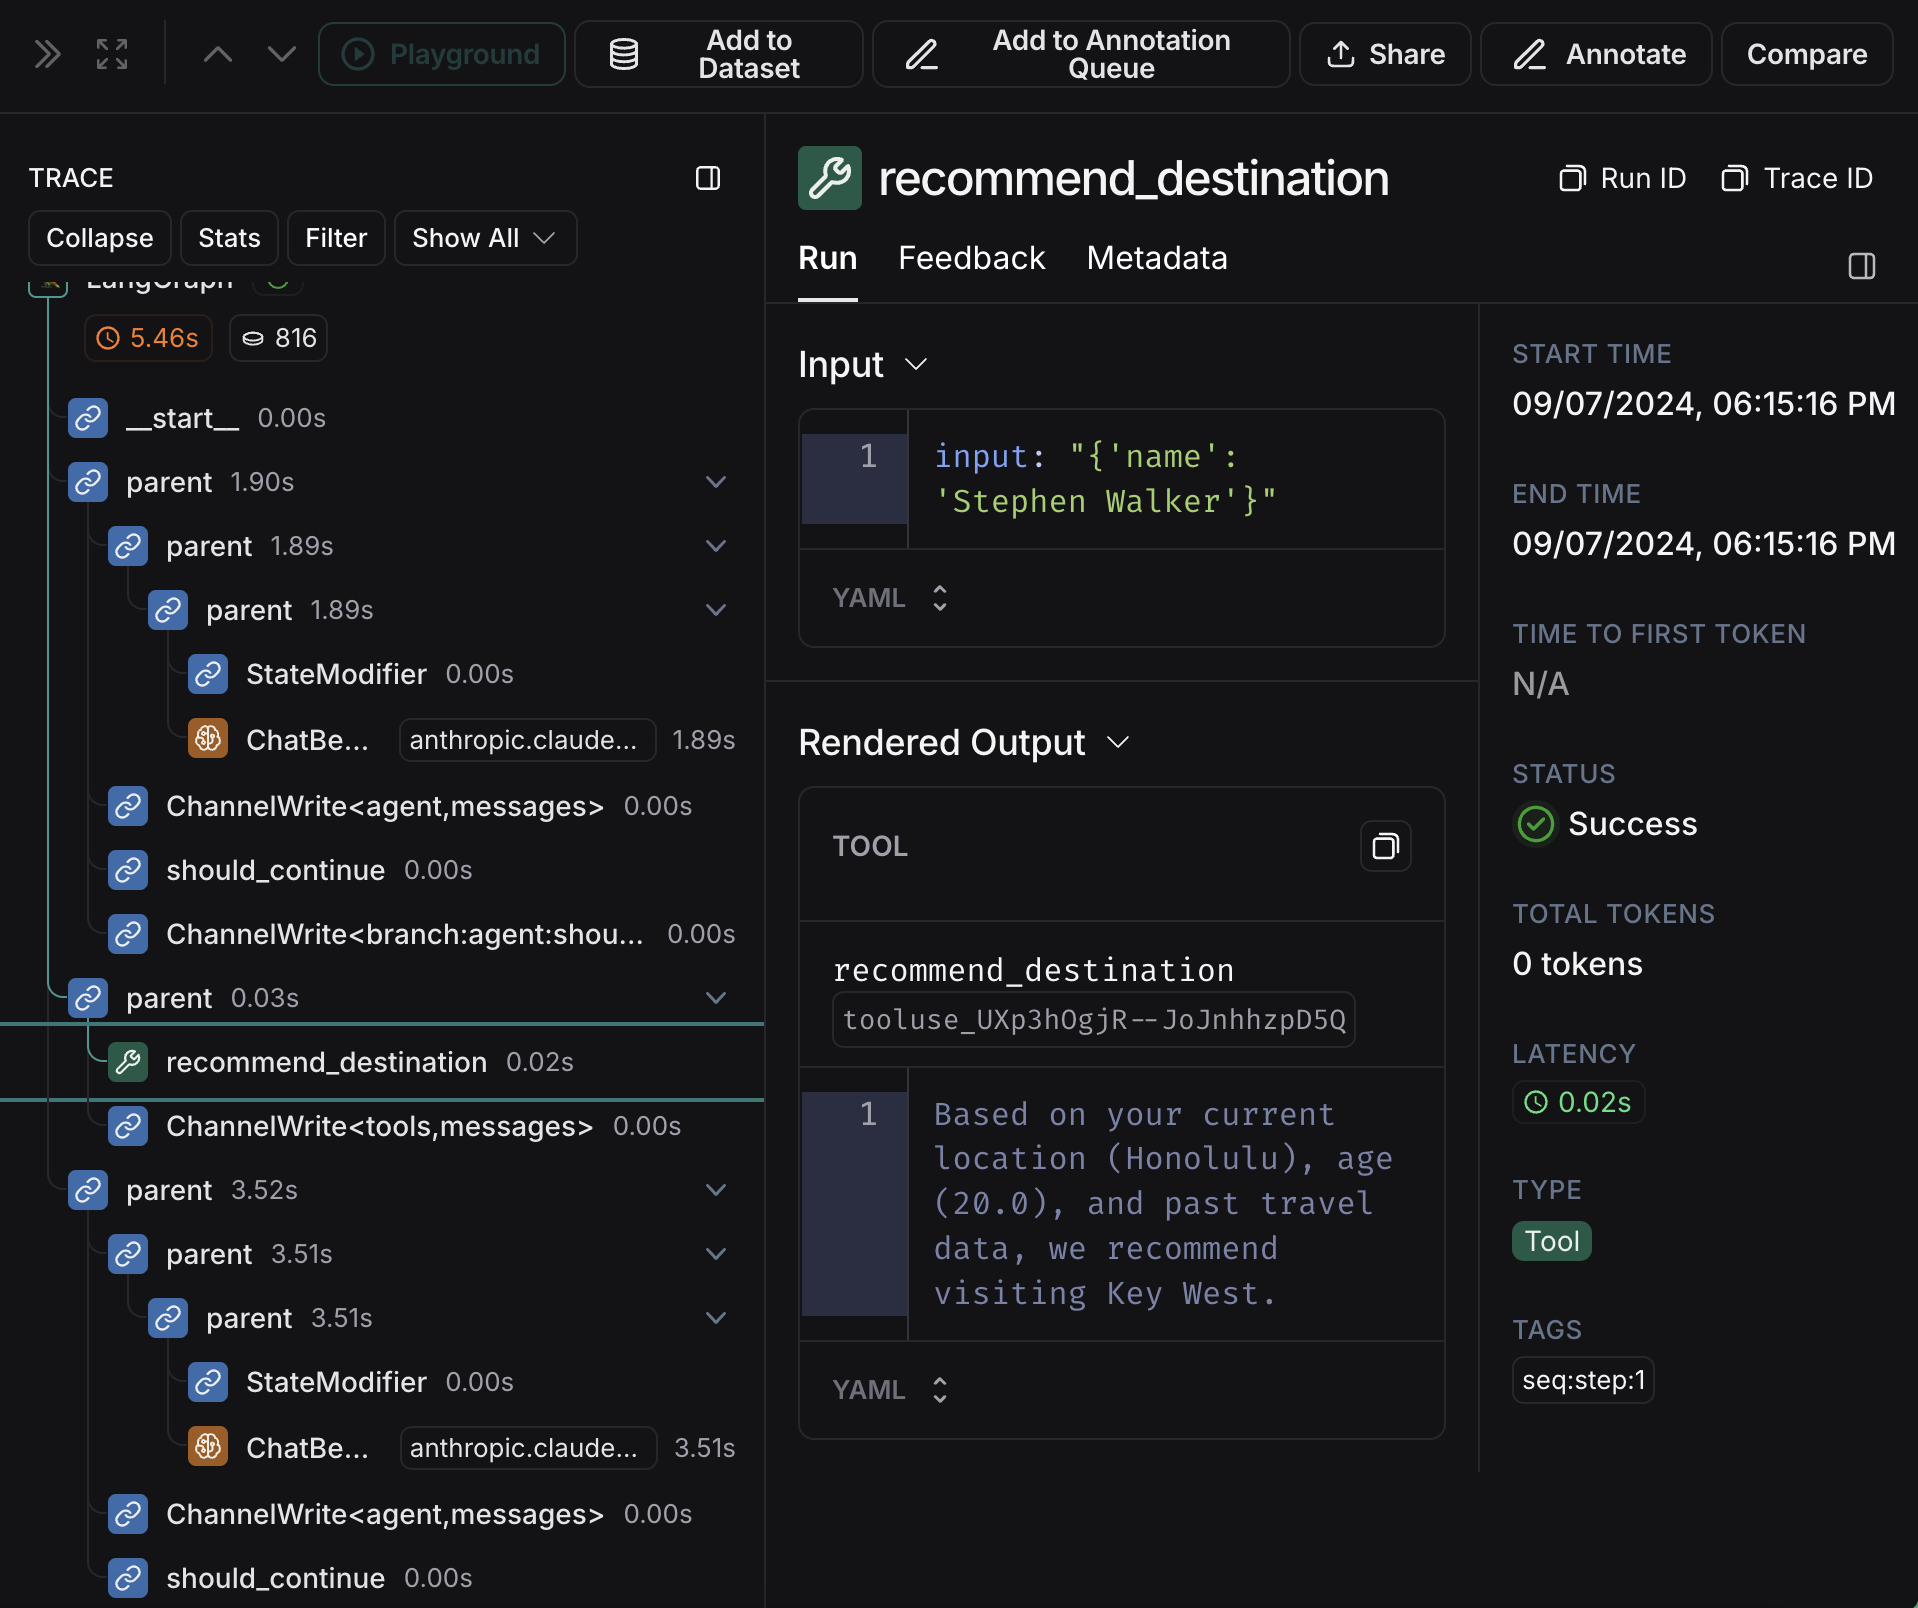

## Memory

Above agent does not remeber previous conversations. We can add memory to our agent by passing checkpointer. When passing in a checkpointer, we also have to pass in a `thread_id` when invoking the agent (so it knows which thread/conversation to resume from).

In [10]:
from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver()

In [11]:
agent_executor = create_react_agent(llm, tools, checkpointer=memory)

config = {"configurable": {"thread_id": "abc123"}}

In [12]:
print(
    agent_executor.invoke(
        {
            "messages": [
                (
                    "user",
                    "My name is Walter Martinez, suggest me a good vacation destination.",
                )
            ]
        },
        config,
    )["messages"][-1].content
)
print("---")
print(
    agent_executor.invoke(
        {
            "messages": [
                ("user", "Give me more information about the location you suggested")
            ]
        },
        config,
    )["messages"][-1].content
)
print("---")

The tool has recommended Stockholm as a vacation destination for you, Walter Martinez. Stockholm is the capital of Sweden and known for its beautiful waterways, medieval old town, innovative design and architecture. Some top attractions include the Vasa Museum housing a 17th century warship, the scenic Stockholm Archipelago, and museums like Skansen open-air museum and Fotografiska photography museum. With its blend of historic charm and modern vibrancy, Stockholm could make for a wonderful vacation spot.
---
Sure, here are some more details about Stockholm that make it an excellent vacation destination:

Gamla Stan (Old Town)
- One of the best preserved medieval city centers in Europe with winding cobblestone streets, colorful buildings, and the Royal Palace.
- Don't miss walking along Västerlånggatan which is one of the most picturesque streets.

Archipelago Cruise
- Stockholm is built across 14 islands connected by bridges. Taking a cruise through the Stockholm archipelago of around

If you notice we are not giving city name in the second input
> Give me more information about the location you suggested

LLM is still able to give more details about the location. This is because it has seen the previous conversation and knows that the AI has suggested Key West.

## From scratch

So far we have seen that LLM is able to decide which tool it has to use. The language model also understands how to combine tools and provide a good response. We have used `create_react_agent` class of LangGraph, which has simplified things for us. 

**But what if we need more control to move from one node to other. What if tool does not have all the inputs to execute the function?  What if we want to directly return the output ut of the tool?**

In this section, we'll explore how to create a more customized and transparent agent using LangGraph. While the `create_react_agent` class provided a convenient high-level interface, we'll now dive deeper to gain more control over the agent's decision-making process and tool usage.

As we defined the tools in the start of this no notebook, we'll use the same tools here. But we need to wrap these tools in a simple `ToolExecutor`. This is a real simple class that takes in a ToolInvocation and calls that tool, returning the output. A `ToolInvocation` is any class with tool and tool_input attribute.

In [13]:
from langgraph.prebuilt import ToolExecutor

tool_executor = ToolExecutor(tools)

/var/folders/yz/xb25qbc160x3myr77yhrcncm0000gr/T/ipykernel_15718/780962383.py:3: LangGraphDeprecationWarning: ToolExecutor is deprecated as of version 0.2.0 and will be removed in 0.3.0. Use langgraph.prebuilt.ToolNode instead.
  tool_executor = ToolExecutor(tools)


As we are not using `create_react_agent`, we need to define a custom bind tool to the LLM. 

In [14]:
llm_with_tools = llm.bind_tools(tools)

## Agent State

The main type of graph in langgraph is the StateGraph. This graph is parameterized by a state object that it passes around to each node. Each node then returns operations to update that state.

In this example we want each node to just add messages to the message list. Therefore, we will use a TypedDict with one key (messages) and annotate it so that the messages attribute is always added to.

In [15]:
import operator
from typing import Annotated, Sequence, TypedDict

from langchain_core.messages import BaseMessage


class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], operator.add]

## Nodes

We now need to define a few different nodes in our graph. In LangGraph, nodes are typically python functions.There are two main nodes we need for this:

The agent: responsible for deciding what (if any) actions to take.
A function to invoke tools: if the agent decides to take an action, this node will then execute that action.

## Edges

Edges define how the logic is routed and how the graph decides to stop. This is a big part of how your agents work and how different nodes communicate with each other. There are a few key types of edges:

- Normal Edges: Go directly from one node to the next.
- Conditional Edges: Call a function to determine which node(s) to go to next.
- Entry Point: Which node to call first when user input arrives.
- Conditional Entry Point: Call a function to determine which node(s) to call first when user input arrives.

In [16]:
from langchain_core.messages import ToolMessage

from langgraph.prebuilt import ToolInvocation

Let's add chatbot node to the graph. It is a python function, which invokes the model. 

The `add_messages` function in our State will append the llm's response messages to whatever messages are already in the state.

In [17]:
from typing import Annotated

from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, MessagesState
from langgraph.graph.message import add_messages


class State(TypedDict):
    messages: Annotated[list, add_messages]


graph_builder = StateGraph(State)


def chatbot(state: State):
    """Always use tools to fullfil user requests. If you do not have enough inputs to execute a tool then you can ask for more information."""
    return {"messages": [llm_with_tools.invoke(state["messages"])]}


graph_builder.add_node("chatbot", chatbot)

We need to create a function to actually run the tools if they are called. We'll do this by adding the tools to a new node. We can use langgraph's `ToolNode` for this.  

In [18]:
from langgraph.prebuilt import ToolNode, tools_condition

tool_node = ToolNode(tools)
graph_builder.add_node("tools", tool_node)

Now we need to define a conditional edge that routes to the tools node when the tools are called in the llm response. We define our own custom function to handle routing or we can use `tools_condition` class of LangGraph. 

In [19]:
graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
    {"tools": "tools", "__end__": "__end__"},
)


Let's add other edges and compile the graph. We can add an entry point. This tells our graph where to start its work each time we run it. We add edges to go from tools node to chatbot node and entry point to chatbot as first node

In [20]:
# Any time a tool is called, we return to the chatbot to decide the next step
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")
graph = graph_builder.compile()

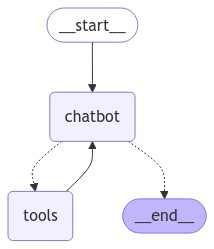

In [21]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

Its time to test our compiled graph. We can use the input the we have used before

> My name is Stephen Walker, suggest me a good vacation destination.

In [22]:
from langchain_core.messages import BaseMessage

while True:
    user_input = input("User: ")
    if user_input.lower() in ["quit", "exit", "q"]:
        print("Goodbye!")
        break
    for event in graph.stream({"messages": [("user", user_input)]}):
        for value in event.values():
            if isinstance(value["messages"][-1], BaseMessage):
                print("Assistant:", value["messages"][-1].content)

Assistant: [{'type': 'text', 'text': 'Okay, let me invoke the tool to check which destinations you have already visited and recommend a new one.'}, {'type': 'tool_use', 'name': 'compare_and_recommend_destination', 'input': {'name': 'Walter Martinez'}, 'id': 'tooluse_dCQArNmXTxu542O0K1wuLQ'}]
Assistant: Based on your current location (Florence), age (28.0), and past travel data, we recommend visiting Stockholm.
Assistant: The tool has recommended Stockholm as a vacation destination for you, Walter Martinez. Stockholm is the capital of Sweden and known for its beautiful archipelago, historic old town (Gamla Stan), excellent museums, and lively food and nightlife scene. With its mix of modern and historic attractions, Stockholm would make for an exciting and culturally rich vacation spot.
Goodbye!


We use the checkpointer that we have seen previously to add memory to the chatbot. If we provide a checkpointer when compiling the graph and a thread_id when calling your graph, LangGraph automatically saves the state after each step. 

We are using checkpointer, which is in-memory storage. This may not be efficient for large graphs or long conversations. For that reason, we can use a `SqliteSaver` or `PostgresSaver` and connect to your own DB.

In [23]:
from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver()
graph = graph_builder.compile(checkpointer=memory)

In [24]:
config = {"configurable": {"thread_id": "1"}}

We can use `thread_id` as a conversation ID to track the conversation. 

In [38]:
from langchain_core.messages import BaseMessage

while True:
    user_input = input("User: ")
    if user_input.lower() in ["quit", "exit", "q"]:
        print("Goodbye!")
        break
    for event in graph.stream({"messages": [("user", user_input)]}, config):
        for value in event.values():
            if isinstance(value["messages"][-1], BaseMessage):
                print("Assistant:", value["messages"][-1].content)

Assistant: [{'type': 'text', 'text': 'Okay, let me invoke the relevant tool to recommend a vacation destination for you, Stephen Walker.'}, {'type': 'tool_use', 'name': 'compare_and_recommend_destination', 'input': {'name': 'Stephen Walker'}, 'id': 'tooluse_OHEwuCw3SKOMxeUMBP5BOA'}]
Assistant: Based on your current location (Honolulu), age (20.0), and past travel data, we recommend visiting Key West.
Assistant: The tool has analyzed your information and recommended Key West as a good vacation destination for you, Stephen Walker. Key West is a beautiful island city in Florida known for its beaches, nightlife, historic sites, and laid-back tropical vibe. As a young adult located in Honolulu, Key West could offer you a nice change of scenery while still providing a warm, coastal setting to enjoy.
Assistant: Sure, here are some more details about Key West that make it an appealing vacation destination:

- Location - Key West is located in the Florida Keys archipelago at the southernmost po

## Return of control for additional inputs

Sometimes, we don't want to execute the tool: there maybe additional input required to execute the tool or we may need human feedback. In this case, we can return control back to the user. We can implement this in LangGraph using a breakpoint: breakpoints allow us to stop graph execution at a specific step. At this breakpoint, we can wait for human input. Once we have input from the user, we can add it to the graph state and proceed. 

We specify the breakpoint using `interrupt_before`

We first need to define a mock tool to ask a user for input. Then we can add this to our existing tools and bind them with the LLM.

In [25]:
from langchain_core import __version__ as core_version
from packaging import version

core_version = version.parse(core_version)
if (core_version.major, core_version.minor) < (0, 3):
    from pydantic.v1 import BaseModel
else:
    from pydantic import BaseModel

class AskHuman(BaseModel):
    """Ask missing information from the user"""

    question: str

Now we define the assistant function. This function takes the graph state, formats it into a prompt, and then calls an LLM for it to predict the best response.

In [26]:
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.runnables import Runnable, RunnableConfig


class Assistant:
    def __init__(self, runnable: Runnable):
        self.runnable = runnable

    def __call__(self, state: State, config: RunnableConfig):
        while True:
            configuration = config.get("configurable", {})
            result = self.runnable.invoke(state)
            # If the LLM happens to return an empty response, we will re-prompt it
            # for an actual response.
            if not result.tool_calls and (
                not result.content
                or isinstance(result.content, list)
                and not result.content[0].get("text")
            ):
                # messages = state["messages"] + [("user", "Respond with a real output.")]
                messages = state["messages"]
                state = {**state, "messages": messages}
            else:
                break
        return {"messages": result}


primary_assistant_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "You are a helpful who can suggest travel destinations"
            " Use the provided tools to look for travel recommendation. "
            " If you dont have enough information then use AskHuman tool to get required information. ",
        ),
        ("placeholder", "{messages}"),
    ]
)

runnable_with_tools = primary_assistant_prompt | llm.bind_tools(tools + [AskHuman])

We also need to define a fake node to ask human

In [27]:
# We define a fake node to ask the human
def ask_human(state):
    pass

Let's also define a function that can handle conditional routing for the edges.

In [28]:

def should_continue(state):
    messages = state["messages"]
    last_message = messages[-1]
    # If there is no function call, then we finish
    if not last_message.tool_calls:
        return "end"
    elif last_message.tool_calls[0]["name"] == "AskHuman":
        return "ask_human"
    # Otherwise if there is, we continue
    else:
        return "continue"

Finally we can build the graph with existing nodes and new node that can ask additional questions from the user.

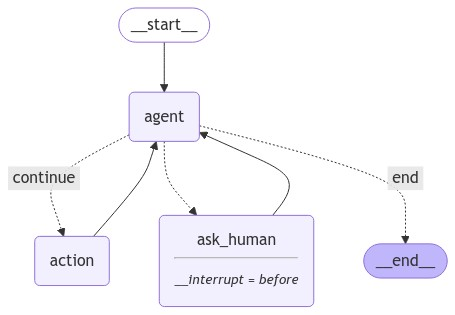

In [29]:
from langgraph.graph import END, StateGraph

# Define a new graph
workflow = StateGraph(MessagesState)

# Define the three nodes we will cycle between
workflow.add_node("agent", Assistant(runnable_with_tools))
workflow.add_node("action", tool_node)
workflow.add_node("ask_human", ask_human)

workflow.add_edge(START, "agent")

# We now add a conditional edge
workflow.add_conditional_edges(
    "agent",
    # Next, we pass in the function that will determine which node is called next.
    should_continue,
    {
        # If `tools`, then we call the tool node.
        "continue": "action",
        # We may ask the human
        "ask_human": "ask_human",
        # Otherwise we finish.
        "end": END,
    },
)


workflow.add_edge("action", "agent")

# After we get back the human response, we go back to the agent
workflow.add_edge("ask_human", "agent")

# Set up memory
from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver()

app = workflow.compile(
    checkpointer=memory,
    interrupt_before=["ask_human"]
)

display(Image(app.get_graph().draw_mermaid_png()))

Let's put this to test

In [30]:
from langchain_core.messages import HumanMessage

config = {"configurable": {"thread_id": "7"}}

input_message = HumanMessage(
    content="I want to book a travel destination"
)
for event in app.stream({"messages": [input_message]}, config, stream_mode="values"):
    event["messages"][-1].pretty_print()

================================ Human Message =================================

I want to book a travel destination
================================== Ai Message ==================================

[{'type': 'text', 'text': "Okay, to recommend a travel destination for you, I'll need some additional information. Let me ask you a few questions:"}, {'type': 'tool_use', 'name': 'AskHuman', 'input': {'question': 'What is your name?'}, 'id': 'tooluse_9BlHkbNlRVKP3LOSSH5FCA'}]
Tool Calls:
  AskHuman (tooluse_9BlHkbNlRVKP3LOSSH5FCA)
 Call ID: tooluse_9BlHkbNlRVKP3LOSSH5FCA
  Args:
    question: What is your name?


We now want to update this thread with a response from the user. We then can kick off another run.

Because we are treating this as a tool call, we will need to update the state as if it is a response from a tool call. In order to do this, we will need to check the state to get the ID of the tool call.

In [31]:
user_input = input("User:")

In [32]:
tool_call_id = app.get_state(config).values["messages"][-1].tool_calls[0]["id"]

# We now create the tool call with the id and the response we want
tool_message = [{"tool_call_id": tool_call_id, "type": "tool", "content": user_input}]


app.update_state(config, {"messages": tool_message}, as_node="ask_human")

app.get_state(config).next

('agent',)

We can now tell the agent to continue. We can just pass in None as the input to the graph, since no additional input is needed

In [33]:
for event in app.stream(None, config, stream_mode="values"):
    event["messages"][-1].pretty_print()

================================= Tool Message =================================

Walter Martinez
================================== Ai Message ==================================

[{'type': 'tool_use', 'name': 'compare_and_recommend_destination', 'input': {'name': 'Walter Martinez'}, 'id': 'tooluse_4HOmPmbaQaOuND7xth0UDg'}]
Tool Calls:
  compare_and_recommend_destination (tooluse_4HOmPmbaQaOuND7xth0UDg)
 Call ID: tooluse_4HOmPmbaQaOuND7xth0UDg
  Args:
    name: Walter Martinez
================================= Tool Message =================================
Name: compare_and_recommend_destination

Based on your current location (Florence), age (28.0), and past travel data, we recommend visiting Stockholm.
================================== Ai Message ==================================

Based on the information provided, I would recommend Stockholm as a travel destination for you, Walter Martinez. Stockholm is the capital of Sweden and offers a beautiful mix of modern attractions and his

## Conclusion

In this notebook, we explored how to create a vacation destination recommendation agent using LangChain and LangGraph. We covered several key concepts and implementations:

1. Setting up tools for the agent to use
2. Implementing a basic agent using the built-in component `create_react_agent` 
3. Adding memory to the agent to maintain context across conversations
4.Building a more customized agent from scratch using LangGraph's `StateGraph`, allowing for greater control over the agent's behavior
5. Implementing a mechanism for the agent to request additional information from the user when needed.
   
This example showcases the flexibility and power Bedrock and LangGraph in creating AI agents that can perform specific tasks while maintaining context and interacting naturally with users. 